## Przewidywanie liganda pasującego do kieszeni wiążącej (embeddingi):

In [7]:
import Voronoi3D
from Bio.PDB import PDBParser
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.layers import Dense, Input
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split


In [2]:
# Buduję listę skrótów aminokwasów (nazwy reszt w PDB występują w postaci skrótów 3-literowych)
AMINOACIDS = set(
    "ALA CYS ASP GLU PHE GLY HIS ILE LYS LEU MET ASN PRO GLN ARG SER THR VAL TRP TYR".split())


In [3]:
# Każdemu aminokwasowi przypisuję jego wektor embedingowy. Wektory są budowane
# z wartości numerycznych następujących własności fizyko-chemicznych:
# masa, objętość, hydrofobowość, punkt izoelektryczny (odpowiednio).
embeddings = {
    "ALA": [89.09404, 88.6, 1.8, 6.11],
    "CYS": [121.15404, 108.5, 2.5, 5.05],
    "ASP": [133.10384, 111.1, -3.5, 2.85],
    "GLU": [147.13074, 138.4, -3.5, 3.15],
    "PHE": [165.19074, 189.9, 2.8, 5.49],
    "GLY": [75.06714, 60.1, -0.4, 6.06],
    "HIS": [155.15634, 153.2, -3.2, 7.60],
    "ILE": [131.17464, 166.7, 4.5, 6.05],
    "LYS": [146.18934, 168.6, -3.9, 9.60],
    "LEU": [131.17464, 166.7, 3.8, 6.01],
    "MET": [149.20784, 162.9, 1.9, 5, 74],
    "ASN": [132.11904, 114.1, -3.5, 5, 41],
    "PRO": [115.13194, 112.7, -1.6, 6.30],
    "GLN": [146.14594, 143.8, -3.5, 5.65],
    "ARG": [174.20274, 173.4, -4.5, 10.76],
    "SER": [105.09344, 89.0, -0.8, 5.68],
    "THR": [119.12034, 116.1, -0.7, 5.60],
    "VAL": [117.14784, 140.0, 4.2, 6.00],
    "TRP": [204.22844, 227.8, -0.9, 5.89],
    "TYR": [181.19124, 193.6, -1.3, 5.64]
}

min_mass = min([vec[0] for vec in embeddings.values()])
max_mass = max([vec[0] for vec in embeddings.values()])

min_volume = min([vec[1] for vec in embeddings.values()])
max_volume = max([vec[1] for vec in embeddings.values()])

min_hydro = min([vec[2] for vec in embeddings.values()])
max_hydro = max([vec[2] for vec in embeddings.values()])

min_pi = min([vec[3] for vec in embeddings.values()])
max_pi = max([vec[3] for vec in embeddings.values()])

# Embeddingi w postaci znormalizowanej.
EMBEDDINGS = {key: np.array([(vec[0] - min_mass) / (max_mass - min_mass), (vec[1] - min_volume) / (max_volume - min_volume), (vec[2] - min_hydro) / (max_hydro - min_hydro), (vec[3] - min_pi) / (max_pi - min_pi)])
              for key, vec in embeddings.items()}


In [4]:
# Ta funkcja służy do wczytania struktury, wyznaczenia jej diagramu Woronoja,
# znalezienia komórek opisujących kieszenie wiążące konkretny ligand (cząsteczek
# może kilka) i finalnie wyznaczenia wektorów reprezentujących te kieszenie
# wiążące.
def vectorize_ligands(structure_path, ligand_name, total_atoms):
    structure_name = structure_path.split("\\")[-1].split(".")[0][3:]

    # Wczytanie struktury, utworzenie diagramu Woronoja
    parser = PDBParser()
    structure = parser.get_structure("STRUCTURE", structure_path)

    coords = [atom.get_coord() for atom in structure.get_atoms()]

    min_x = min(coords, key=lambda coord: coord[0])[0]
    max_x = max(coords, key=lambda coord: coord[0])[0]

    min_y = min(coords, key=lambda coord: coord[1])[1]
    max_y = max(coords, key=lambda coord: coord[1])[1]

    min_z = min(coords, key=lambda coord: coord[2])[2]
    max_z = max(coords, key=lambda coord: coord[2])[2]

    container = Voronoi3D.RectangularContainer(
        min_x, max_x, min_y, max_y, min_z, max_z)

    for residue in structure.get_residues():
        for atom in residue.get_atoms():
            if atom.get_name()[0] != "H" and residue.get_resname() != "HOH":
                container.add(atom.get_serial_number(), *atom.get_coord(), residue=residue.get_resname(),
                              atom=atom.get_name(), seg_id=residue.get_full_id()[3][1])

    diagram = Voronoi3D.Diagram(container)

    # ---------------------------------------------------------------------------------

    # Wybranie komórek zawierających ligand

    ligands_cells = []
    prev_res = -1

    for cell in diagram:
        if cell.generator.residue == ligand_name:
            if cell.generator.seg_id == prev_res:
                ligands_cells[-1].append(cell)
            else:
                ligands_cells.append([cell])
                prev_res = cell.generator.seg_id

    # ---------------------------------------------------------------------------------

    # Wyznaczenie sąsiadów ligandów (reszt aminokwasowych dookoła liganda)

    ligands_neighbors = []
    ligands_volumes_surfaces = []

    for ligand in ligands_cells:
        if len(ligand) == total_atoms:
            cells_ids = set([cell.generator.id for cell in ligand])
            ligand_atoms = {cell.generator.atom: [] for cell in ligand}

            volume = 0.0
            surface = 0.0
            for cell in ligand:
                volume += cell.volume

                for face in cell:
                    if face.neighbor not in cells_ids:
                        surface += face.area
                        residue = diagram.cell(face.neighbor).generator.residue
                        if residue in AMINOACIDS:
                            ligand_atoms[cell.generator.atom].append(residue)

            ligands_neighbors.append(ligand_atoms)
            ligands_volumes_surfaces.append((volume, surface))

    # ---------------------------------------------------------------------------------

    # Wektoryzacja znalezionych kieszeni wiążących

    vectors = []

    for (volume, surface), ligand in zip(ligands_volumes_surfaces, ligands_neighbors):
        atoms = [(atom, neighbors) for atom, neighbors in ligand.items()]
        atoms.sort(key=lambda x: x[0])

        vector = []

        for atom, neighbors in atoms:
            if len(neighbors) != 0:
                vector.append(sum([EMBEDDINGS[res]
                              for res in neighbors]) / len(neighbors))
            else:
                vector.append(np.zeros(len(EMBEDDINGS["GLY"])))

        vector = np.vstack(vector)
        vectors.append((structure_name, volume, surface, vector.flatten()))

    return vectors


In [6]:
# Tym razem każde miejsce wiązania reprezentowane jest jako wektor w przetrzeni
# zredukowanej (podobnie jak w problemie grupowania)

dataset = []

# Wczytanie CLR
ligand = "CLR"
pdb_files = glob.glob(f"..\\data\\{ligand}\\*")

vectors = []

for pdb_file in pdb_files:
    vectors += vectorize_ligands(pdb_file, ligand, 28)

vectors_reshape = np.vstack([vector[3] for vector in vectors])
pca = PCA(20)
vectors_pca = pca.fit_transform(vectors_reshape)

for vec in vectors_pca:
    dataset.append((vec, [1, 0, 0, 0, 0, 0]))


# Wczytanie ATP
ligand = "ATP"
pdb_files = glob.glob(f"..\\data\\{ligand}\\*")

vectors = []

for pdb_file in pdb_files:
    vectors += vectorize_ligands(pdb_file, ligand, 31)

vectors_reshape = np.vstack([vector[3] for vector in vectors])
pca = PCA(20)
vectors_pca = pca.fit_transform(vectors_reshape)

for vec in vectors_pca:
    dataset.append((vec, [0, 1, 0, 0, 0, 0]))


# Wczytanie NDP
ligand = "NDP"
pdb_files = glob.glob(f"..\\data\\{ligand}\\*")

vectors = []

for pdb_file in pdb_files:
    vectors += vectorize_ligands(pdb_file, ligand, 48)

vectors_reshape = np.vstack([vector[3] for vector in vectors])
pca = PCA(20)
vectors_pca = pca.fit_transform(vectors_reshape)

for vec in vectors_pca:
    dataset.append((vec, [0, 0, 1, 0, 0, 0]))


# Wczytanie UPG
ligand = "UPG"
pdb_files = glob.glob(f"..\\data\\{ligand}\\*")

vectors = []

for pdb_file in pdb_files:
    vectors += vectorize_ligands(pdb_file, ligand, 36)

vectors_reshape = np.vstack([vector[3] for vector in vectors])
pca = PCA(20)
vectors_pca = pca.fit_transform(vectors_reshape)

for vec in vectors_pca:
    dataset.append((vec, [0, 0, 0, 1, 0, 0]))


# Wczytanie GLC
ligand = "GLC"
pdb_files = glob.glob(f"..\\data\\{ligand}\\*")

vectors = []

for pdb_file in pdb_files:
    vectors += vectorize_ligands(pdb_file, ligand, 12)

vectors_reshape = np.vstack([vector[3] for vector in vectors])
pca = PCA(20)
vectors_pca = pca.fit_transform(vectors_reshape)

for vec in vectors_pca:
    dataset.append((vec, [0, 0, 0, 0, 1, 0]))


# Wczytanie BGC
ligand = "BGC"
pdb_files = glob.glob(f"..\\data\\{ligand}\\*")

vectors = []

for pdb_file in pdb_files:
    vectors += vectorize_ligands(pdb_file, ligand, 12)

vectors_reshape = np.vstack([vector[3] for vector in vectors])
pca = PCA(20)
vectors_pca = pca.fit_transform(vectors_reshape)

for vec in vectors_pca:
    dataset.append((vec, [0, 0, 0, 0, 0, 1]))


c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4717.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4746.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4775.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4826.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4870.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\P

In [18]:
# Tworzenie zbiorów uczącego i testowego (80:20).

random.shuffle(dataset)

samples = [x[0] for x in dataset]
labels = [x[1] for x in dataset]

samples_train, samples_test, labels_train, labels_test = train_test_split(
    samples, labels, test_size=0.2)

samples_train = np.array(samples_train)
samples_test = np.array(samples_test)

labels_train = np.array(labels_train)
labels_test = np.array(labels_test)


### Przegląd architektur sieci neuronowych:

In [19]:
model = Sequential([
    Dense(20, activation='relu'),
    Dense(256, kernel_initializer="normal", activation='relu'),
    Dense(128, kernel_initializer="normal", activation='relu'),
    Dense(64, kernel_initializer="normal", activation='relu'),
    Dense(6, kernel_initializer="normal", activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [20]:
hist = model.fit(samples_train, labels_train,
                 batch_size=8, epochs=70,
                 validation_data=(samples_test, labels_test))

Epoch 1/70
137/137 [==============================] - 1s 2ms/step - loss: 1.7572 - accuracy: 0.1928 - val_loss: 1.7380 - val_accuracy: 0.2198
Epoch 2/70
137/137 [==============================] - 0s 1ms/step - loss: 1.6016 - accuracy: 0.3223 - val_loss: 1.4653 - val_accuracy: 0.3846
Epoch 3/70
137/137 [==============================] - 0s 1ms/step - loss: 1.3644 - accuracy: 0.4123 - val_loss: 1.3511 - val_accuracy: 0.3883
Epoch 4/70
137/137 [==============================] - 0s 1ms/step - loss: 1.2528 - accuracy: 0.4316 - val_loss: 1.3013 - val_accuracy: 0.4469
Epoch 5/70
137/137 [==============================] - 0s 1ms/step - loss: 1.1525 - accuracy: 0.4702 - val_loss: 1.2092 - val_accuracy: 0.4579
Epoch 6/70
137/137 [==============================] - 0s 1ms/step - loss: 1.0227 - accuracy: 0.5592 - val_loss: 1.1539 - val_accuracy: 0.4652
Epoch 7/70
137/137 [==============================] - 0s 1ms/step - loss: 0.9101 - accuracy: 0.6198 - val_loss: 1.0468 - val_accuracy: 0.5641
Epoch 

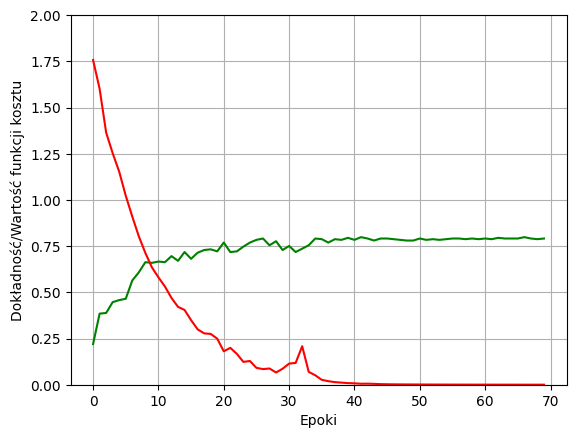

In [21]:
plt.plot(hist.epoch, hist.history["val_accuracy"], color="green")
plt.plot(hist.epoch, hist.history["loss"], color="red")
plt.ylim(0, 2)
plt.xlabel("Epoki")
plt.ylabel("Dokładność/Wartość funkcji kosztu")
plt.grid()
plt.show()

In [22]:
pred = model.predict(samples_test)

count = 0

for pred_vec, label_vec in zip(pred, labels_test):
    if np.argmax(pred_vec) == np.argmax(label_vec):
        count += 1

print(f"Dokładność: {round(count * 100 / len(labels_test), 3)}%")

9/9 [==============================] - 0s 864us/step
Dokładność: 79.121%


In [23]:
model = Sequential([
    Dense(20, activation='relu'),
    Dense(512, kernel_initializer="normal", activation='relu'),
    Dense(256, kernel_initializer="normal", activation='relu'),
    Dense(64, kernel_initializer="normal", activation='relu'),
    Dense(6, kernel_initializer="normal", activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [24]:
hist = model.fit(samples_train, labels_train,
                 batch_size=8, epochs=70,
                 validation_data=(samples_test, labels_test))

Epoch 1/70
137/137 [==============================] - 1s 3ms/step - loss: 1.7365 - accuracy: 0.2094 - val_loss: 1.6618 - val_accuracy: 0.3223
Epoch 2/70
137/137 [==============================] - 0s 3ms/step - loss: 1.4686 - accuracy: 0.3820 - val_loss: 1.4466 - val_accuracy: 0.3810
Epoch 3/70
137/137 [==============================] - 0s 2ms/step - loss: 1.3122 - accuracy: 0.3985 - val_loss: 1.2952 - val_accuracy: 0.4432
Epoch 4/70
137/137 [==============================] - 0s 2ms/step - loss: 1.1581 - accuracy: 0.4913 - val_loss: 1.2053 - val_accuracy: 0.4505
Epoch 5/70
137/137 [==============================] - 0s 2ms/step - loss: 0.9947 - accuracy: 0.5601 - val_loss: 1.1035 - val_accuracy: 0.5128
Epoch 6/70
137/137 [==============================] - 0s 2ms/step - loss: 0.8539 - accuracy: 0.6097 - val_loss: 0.9190 - val_accuracy: 0.6154
Epoch 7/70
137/137 [==============================] - 0s 2ms/step - loss: 0.6994 - accuracy: 0.6786 - val_loss: 0.8850 - val_accuracy: 0.6777
Epoch 

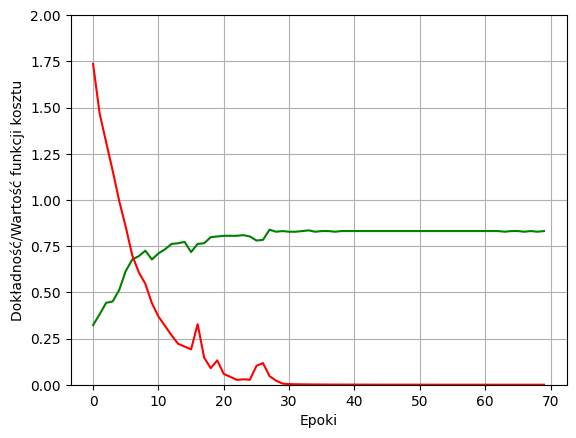

In [25]:
plt.plot(hist.epoch, hist.history["val_accuracy"], color="green")
plt.plot(hist.epoch, hist.history["loss"], color="red")
plt.ylim(0, 2)
plt.xlabel("Epoki")
plt.ylabel("Dokładność/Wartość funkcji kosztu")
plt.grid()
plt.show()

In [26]:
pred = model.predict(samples_test)

count = 0

for pred_vec, label_vec in zip(pred, labels_test):
    if np.argmax(pred_vec) == np.argmax(label_vec):
        count += 1

print(f"Dokładność: {round(count * 100 / len(labels_test), 3)}%")

9/9 [==============================] - 0s 1ms/step
Dokładność: 83.15%


In [27]:
model = Sequential([
    Dense(20, activation='relu'),
    Dense(512, kernel_initializer="normal", activation='relu'),
    Dense(256, kernel_initializer="normal", activation='relu'),
    Dense(128, kernel_initializer="normal", activation='relu'),
    Dense(64, kernel_initializer="normal", activation='relu'),
    Dense(6, kernel_initializer="normal", activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [28]:
hist = model.fit(samples_train, labels_train,
                 batch_size=8, epochs=70,
                 validation_data=(samples_test, labels_test))

Epoch 1/70
137/137 [==============================] - 2s 3ms/step - loss: 1.7553 - accuracy: 0.2048 - val_loss: 1.7502 - val_accuracy: 0.2198
Epoch 2/70
137/137 [==============================] - 0s 2ms/step - loss: 1.6094 - accuracy: 0.3104 - val_loss: 1.4293 - val_accuracy: 0.3370
Epoch 3/70
137/137 [==============================] - 0s 2ms/step - loss: 1.3656 - accuracy: 0.3848 - val_loss: 1.4998 - val_accuracy: 0.3150
Epoch 4/70
137/137 [==============================] - 0s 2ms/step - loss: 1.2818 - accuracy: 0.3756 - val_loss: 1.3218 - val_accuracy: 0.3883
Epoch 5/70
137/137 [==============================] - 0s 2ms/step - loss: 1.1331 - accuracy: 0.4738 - val_loss: 1.2957 - val_accuracy: 0.3919
Epoch 6/70
137/137 [==============================] - 0s 2ms/step - loss: 1.0481 - accuracy: 0.5078 - val_loss: 1.1567 - val_accuracy: 0.5201
Epoch 7/70
137/137 [==============================] - 0s 2ms/step - loss: 0.8940 - accuracy: 0.5895 - val_loss: 1.2112 - val_accuracy: 0.5385
Epoch 

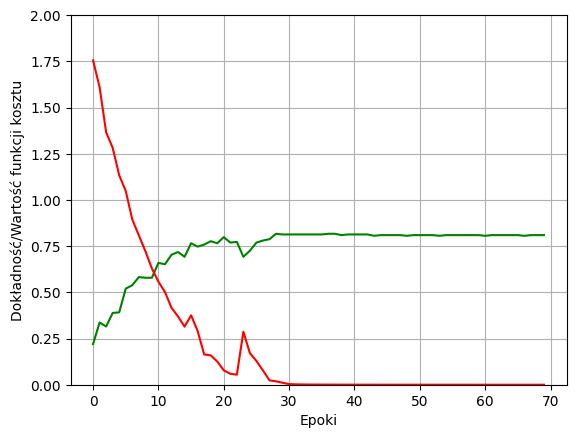

In [29]:
plt.plot(hist.epoch, hist.history["val_accuracy"], color="green")
plt.plot(hist.epoch, hist.history["loss"], color="red")
plt.ylim(0, 2)
plt.xlabel("Epoki")
plt.ylabel("Dokładność/Wartość funkcji kosztu")
plt.grid()
plt.show()

In [30]:
pred = model.predict(samples_test)

count = 0

for pred_vec, label_vec in zip(pred, labels_test):
    if np.argmax(pred_vec) == np.argmax(label_vec):
        count += 1

print(f"Dokładność: {round(count * 100 / len(labels_test), 3)}%")

9/9 [==============================] - 0s 1ms/step
Dokładność: 80.952%


### Wnioski:
- Przy tym kodowaniu model osiąga podobną (trochę gorszą) dokładność jak przy kodowaniu one-hot,
- To kodowanie wymaga pojemniejszego modelu (więcej neuronów, więcej warstw)